In [1]:
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
import xarray as xr
import warnings
warnings.filterwarnings('ignore')
import cmocean
import metpy.calc as mtpy
import xesmf as xe
from math import log10, floor
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
cd /home/563/slf563/code/gadi/jk72/CMIP_eval/

/home/563/slf563/code/gadi/jk72/CMIP_eval


# Read in initial data
- The list of CMIP6 models has been generated by: https://clef.readthedocs.io/en/latest/

In [3]:
t = pd.DataFrame(index=['Start','End'],columns=['historical','ssp245'])
t.historical = ['1985-01','2014-12']
t.ssp245 = ['2071-01','2100-12']

In [4]:
listname='/g/data/jk72/slf563/CMIP6/CMIP6_query_fast_ice_review.csv'
file_list = pd.read_csv(listname)
file_list= file_list.drop(columns=['sub_experiment_id','Unnamed: 0','index','activity_id','frequency','member_id','time_complete','variable_id'])

In [5]:
fast_ice = xr.open_dataset('/g/data/jk72/slf563/OBS/SIC/fast_ice/fastice_v2.2_persistence.nc')
fast_ice.longitude.values[fast_ice.longitude.values<0] += 360
fast_ice.iceshelfmask.values[fast_ice.latitude.values > -75] = np.nan

### check fast ice data

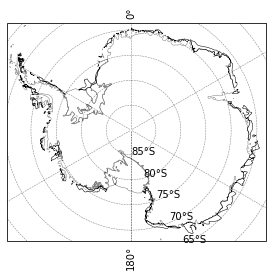

In [6]:
ax = plt.subplot(111, projection=ccrs.SouthPolarStereo())
ax.set_extent([-2790554, 3033445, -2489655, 2409344], ccrs.SouthPolarStereo(central_longitude=0.0))
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.coastlines(linewidths=[0.5],color='grey')   

plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.iceshelfmask.fillna(0),
           levels=[1],colors=['grey'],linewidths=[0.5],transform=ccrs.PlateCarree())
plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.persistence,
           levels=[0.25],colors=['black'],linewidths=[0.5],transform=ccrs.PlateCarree())

# Functions

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
def regrid(ds_in, var, method='bilinear'):
    
    ds_out = xe.util.grid_global(1, 1)
    
    if ('nav_lon' in list(ds_in.coords)) and ('nav_lat' in list(ds_in.coords)):
        ds_in = ds_in.rename({'nav_lat':'lat','nav_lon':'lon'})
    if ('latitude' in list(ds_in.coords)) and ('longitude' in list(ds_in.coords)):
        ds_in = ds_in.rename({'latitude':'lat','longitude':'lon'}) 
    
    regridder = xe.Regridder(ds_in, ds_out, method, periodic=True,ignore_degenerate=True)
    dr_out = regridder(ds_in[var])
    return dr_out

In [9]:
def get_data(var):
    print('Reading {}'.format(var))
    fname = '/g/data/jk72/slf563/CMIP6/CMIP6_fast_ice_ensemble_{}.nc'.format(var)
    if os.path.isfile(fname):
        
        models_all = xr.open_dataset(fname)
    
    else:
    
        models_all= xr.Dataset()
        for scn in ['historical','ssp245']:
            tmp_list = file_list[(file_list.variable==var) & (file_list.experiment_id==scn)]
            for i in range(len(tmp_list)):
                fdir = '{}/*.nc'.format(tmp_list.path.iloc[i])
                data = xr.open_mfdataset(fdir)
                data = data.sel(time=slice(t[scn].Start,t[scn].End))
                data = data.assign_coords({'Model':'{} {}'.format(tmp_list.source_id.iloc[i],tmp_list.variant_label.iloc[i])})
                data = data.assign_coords({'Scenario':tmp_list.experiment_id.iloc[i]})    

                data = regrid(data, var)

                data = data.groupby('time.season').mean()
                
                if var=='siconc' and 'type' in list(data.coords):
                    data = data.drop('type')

                if i == 0: 
                    models = data
                else: 
                    models = xr.concat([models,data],dim='Model')

            if scn == 'historical': 
                models_all = models
            else: 
                models_all = xr.concat([models_all,models],dim='Scenario')
        models_all.to_netcdf(fname)

    return models_all

In [10]:
def plot_properties(sub,data,title,levels,cmap='viridis',supress_alpha='No',cbar_plot=False):
    abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    ax = plt.subplot(sub[0],sub[1],sub[2], projection=ccrs.SouthPolarStereo())
    ax.set_extent([-2790554, 3033445, -2489655, 2409344], ccrs.SouthPolarStereo(central_longitude=0.0))
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='black', alpha=0.5, linestyle='--')
    
    
    p = plt.contourf(data.lon,data.lat,data,
                    cmap=cmap,
                    transform=ccrs.PlateCarree(),
                    levels=levels,
                    add_colorbar=cbar_plot,
                    extend='both',
                    );

    plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.iceshelfmask.fillna(0),
               levels=[1],colors=['grey'],linewidths=[0.5],transform=ccrs.PlateCarree())
    #plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.groundedmask.fillna(0),
    #           levels=[1],colors=['grey'],linewidths=[0.8],transform=ccrs.PlateCarree())
    plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.persistence,
               levels=[0.25],colors=['black'],linewidths=[0.5],transform=ccrs.PlateCarree())
    ax.coastlines(linewidths=[0.5],color='grey')
    
    plt.title('');
    if supress_alpha == 'Yes': 
        plt.title('{}'.format(title),loc='center');    
    else: 
        plt.title('{}) {}'.format(abc[sub[2]-1],title),loc='left');
    return(p)

In [11]:
def plot_CMIP(models,title,units,levels,cmap2="RdBu"):
          
    fig = plt.figure(figsize=(11,3))

    p2 = plot_properties([1,4,1],
                         models.sel(Scenario='ssp245',season='DJF').mean('Model')-models.sel(Scenario='historical',season='DJF').mean('Model'),
                         'DJF',levels,cmap=cmap2);
    p2 = plot_properties([1,4,2],
                         models.sel(Scenario='ssp245',season='MAM').mean('Model')-models.sel(Scenario='historical',season='MAM').mean('Model'),
                         'MAM',levels,cmap=cmap2);
    p2 = plot_properties([1,4,3],
                         models.sel(Scenario='ssp245',season='JJA').mean('Model')-models.sel(Scenario='historical',season='JJA').mean('Model'),
                         'JJA',levels,cmap=cmap2);
    p2 = plot_properties([1,4,4],
                         models.sel(Scenario='ssp245',season='SON').mean('Model')-models.sel(Scenario='historical',season='SON').mean('Model'),
                         'SON',levels,cmap=cmap2);
    plt.suptitle(title,y=0.92,size=14)

    cax = plt.axes([0.88, 0.15, 0.03, 0.6])
    plt.colorbar(p2,cax=cax,label=units,);
    plt.subplots_adjust(right=0.87,left=0.02,bottom=0.02,wspace=0.02)
    

In [12]:
def round_sig(x, sig=2):
    return np.round(x, sig-int(floor(log10(abs(x))))-1)

In [13]:
def calc_means(anoms,means,data,var,sig=2):
    for sea in ['DJF','MAM','JJA','SON']:
        means.loc[var][sea] = round_sig(((data[var].sel(Scenario='historical',season=sea).mean('Model'))*weights).mean().values,sig)
        anoms.loc[var][sea] = round_sig(((data[var].sel(Scenario='ssp245',season=sea).mean('Model') - 
        data[var].sel(Scenario='historical',season=sea).mean('Model'))*weights).mean().values,sig)
    return anoms,means

# Read in CMIP6 data 
Either generate data for the first time or read in the previously generated files 

In [14]:
models_tas = get_data('tas')
models_tasmin = get_data('tasmin')
models_tasmax = get_data('tasmax')

models_pr = get_data('pr')
models_prsn = get_data('prsn')
models_prl = models_pr.pr - models_prsn.prsn # get liquid only 
models_prl = models_prl.rename('prl').to_dataset()
models_prsn = models_prsn * 60 * 60 * 24 # kg/m2/s to kg/m2/day 
models_prl = models_prl * 60 * 60 * 24 # kg/m2/s to kg/m2/day
ndays = xr.DataArray([90,91,92,92],dims='season')
ndays.assign_coords({'season':models_prsn.season.values})
models_prsn = models_prsn*ndays # kg/m2/day to kg/m2/season
models_prl = models_prl*ndays # kg/m2/day to kg/m2/season

models_psl = get_data('psl')
models_psl = models_psl/100 # Pa to hPa

models_rsds = get_data('rsds')

models_uas = get_data('uas')
models_vas = get_data('vas')
models_uas['uas']  = models_uas.uas.assign_attrs({'units':'m s-1'})
models_vas['vas']  = models_vas.vas.assign_attrs({'units':'m s-1'})
models_wspd = mtpy.wind_speed(models_uas.uas, models_vas.vas)
models_wspd = models_wspd.rename('wspd').to_dataset()

models_tos = get_data('tos')
models_siconc = get_data('siconc')
models_sithick = get_data('sithick')


Reading tas
Reading tasmin
Reading tasmax
Reading pr
Reading prsn
Reading psl
Reading rsds
Reading uas
Reading vas
Reading tos
Reading siconc
Reading sithick


# Calc means
- Inititialise array for means 
- Regrid fast ice to same grid as CMIP6 data
- Calc means

In [15]:
varlist = ['tas','tasmin','tasmax','prl','prsn','rsds','psl','uas','vas','wspd','tos','sithick','siconc']

In [16]:
anoms = pd.DataFrame(index=varlist,columns=['DJF','MAM','JJA','SON'])
means = pd.DataFrame(index=varlist,columns=['DJF','MAM','JJA','SON'])

In [17]:
new_fast = regrid(fast_ice,'persistence')
weights = new_fast.copy()
weights = weights.where(weights>0.0,np.nan)
weights = weights.where(np.isnan(weights),1)

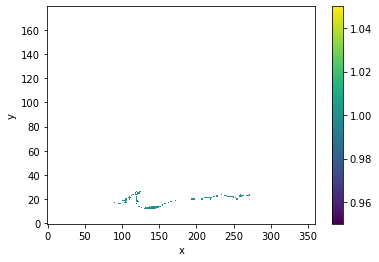

In [18]:
weights.plot()

In [19]:
anoms,means = calc_means(anoms,means,models_tas,'tas',sig=5)
anoms,means = calc_means(anoms,means,models_tasmin,'tasmin',sig=5)
anoms,means = calc_means(anoms,means,models_tasmax,'tasmax',sig=5)
anoms,means = calc_means(anoms,means,models_prsn,'prsn')
anoms,means = calc_means(anoms,means,models_prl,'prl')
anoms,means = calc_means(anoms,means,models_psl,'psl')
anoms,means = calc_means(anoms,means,models_rsds,'rsds')
anoms,means = calc_means(anoms,means,models_uas,'uas')
anoms,means = calc_means(anoms,means,models_vas,'vas')
anoms,means = calc_means(anoms,means,models_wspd,'wspd')
anoms,means = calc_means(anoms,means,models_tos,'tos')
anoms,means = calc_means(anoms,means,models_sithick,'sithick')
anoms,means = calc_means(anoms,means,models_siconc,'siconc')

In [20]:
latex = pd.DataFrame(index=varlist,columns=['Feild','DJF','MAM','JJA','SON',])

In [21]:
latex['Feild'] =  ['Mean temperature at surface (K)',
                   'Minimum temperature at surface (K)',
                   'Maximum temperature at surface (K)',
                   'Rainfall (mm\,season$^{-1}$)',
                   'Snowfall (mm\,season$^{-1}$)',
                   'Incoming shortwave radiation (W\,m$^{-2}$)',
                   'Mean sea level pressure (hPa)',
                   'U wind component (m\,s$^{-1}$)',
                   'V wind component (m\,s$^{-1}$)',
                   'Mean wind speed (m\,s$^{-1}$)',
                   'Sea surface temperature (K)',
                   'Sea ice thickness (m)',
                   'Sea ice concentration (Percent)',]

In [22]:
for var in varlist: 
    for sea in ['DJF','MAM','JJA','SON']: 
        latex[sea][var] = '{} ({})'.format(anoms[sea][var],means[sea][var])

In [23]:
print(latex.to_latex(index=False,escape=False)) 

\begin{tabular}{lllll}
\toprule
                                     Feild &             DJF &             MAM &             JJA &             SON \\
\midrule
           Mean temperature at surface (K) & 1.8363 (271.01) & 2.9591 (262.55) & 3.4114 (254.78) & 2.2346 (259.99) \\
        Minimum temperature at surface (K) & 2.0958 (269.65) & 3.1836 (260.67) &  3.6257 (252.3) &  2.5152 (257.3) \\
        Maximum temperature at surface (K) & 1.6358 (272.16) & 2.7315 (264.38) & 3.1845 (257.24) &  1.979 (262.41) \\
              Rainfall (mm\,season$^{-1}$) &     26.0 (40.0) &     22.0 (28.0) &       4.4 (3.6) &       3.5 (4.4) \\
              Snowfall (mm\,season$^{-1}$) &    -14.0 (78.0) &     6.3 (160.0) &    20.0 (140.0) &     9.9 (130.0) \\
Incoming shortwave radiation (W\,m$^{-2}$) &   -13.0 (250.0) &     -2.1 (35.0) &     -0.21 (4.9) &    -6.2 (170.0) \\
             Mean sea level pressure (hPa) &    -1.1 (990.0) &    -1.8 (990.0) &    -1.9 (990.0) &   -0.75 (990.0) \\
            U w

# Final plots

In [ ]:
fig = plt.figure(figsize=(11,12))

#*******************************************
# Temp 
cmap2=truncate_colormap(cmocean.cm.balance,0.5,1)
levels=np.arange(0,5.1,0.1)

p1 = plot_properties([5,4,1],
                     models_tas.tas.sel(Scenario='ssp245',season='DJF').mean('Model')-models_tas.tas.sel(Scenario='historical',season='DJF').mean('Model'),
                     'DJF',levels,cmap=cmap2);
p1 = plot_properties([5,4,2],
                     models_tas.tas.sel(Scenario='ssp245',season='MAM').mean('Model')-models_tas.tas.sel(Scenario='historical',season='MAM').mean('Model'),
                     'MAM',levels,cmap=cmap2);
p1 = plot_properties([5,4,3],
                     models_tas.tas.sel(Scenario='ssp245',season='JJA').mean('Model')-models_tas.tas.sel(Scenario='historical',season='JJA').mean('Model'),
                     'JJA',levels,cmap=cmap2);
p1 = plot_properties([5,4,4],
                     models_tas.tas.sel(Scenario='ssp245',season='SON').mean('Model')-models_tas.tas.sel(Scenario='historical',season='SON').mean('Model'),
                     'SON',levels,cmap=cmap2);

cax1 = plt.axes([0.88, 0.72, 0.03, 0.15])
plt.colorbar(p1,cax=cax1,label='K');
plt.figtext(x=0.45,y=0.97,s='2m air temperature',ha='center',fontsize=14)

#*******************************************
# SSTs 
cmap2=truncate_colormap(cmocean.cm.balance,0.5,1)
levels=np.arange(0,2.1,0.1)

p2 = plot_properties([5,4,5],
                     models_tos.tos.sel(Scenario='ssp245',season='DJF').mean('Model')-models_tos.tos.sel(Scenario='historical',season='DJF').mean('Model'),
                     'DJF',levels,cmap=cmap2);
p2 = plot_properties([5,4,6],
                     models_tos.tos.sel(Scenario='ssp245',season='MAM').mean('Model')-models_tos.tos.sel(Scenario='historical',season='MAM').mean('Model'),
                     'MAM',levels,cmap=cmap2);
p2 = plot_properties([5,4,7],
                     models_tos.tos.sel(Scenario='ssp245',season='JJA').mean('Model')-models_tos.tos.sel(Scenario='historical',season='JJA').mean('Model'),
                     'JJA',levels,cmap=cmap2);
p2 = plot_properties([5,4,8],
                     models_tos.tos.sel(Scenario='ssp245',season='SON').mean('Model')-models_tos.tos.sel(Scenario='historical',season='SON').mean('Model'),
                     'SON',levels,cmap=cmap2);

cax2 = plt.axes([0.88, 0.65, 0.03, 0.15])
plt.colorbar(p2,cax=cax2,label='K');
plt.figtext(x=0.45,y=0.8,s='Sea surface temperature',ha='center',fontsize=14)

#*******************************************
# Rain 
levels=np.arange(-100,105,5)
cmap2=cmocean.cm.balance_r

p3 = plot_properties([5,4,9],
                     models_prl.prl.sel(Scenario='ssp245',season='DJF').mean('Model')-models_prl.prl.sel(Scenario='historical',season='DJF').mean('Model'),
                     'DJF',levels,cmap=cmap2);
p3 = plot_properties([5,4,10],
                     models_prl.prl.sel(Scenario='ssp245',season='MAM').mean('Model')-models_prl.prl.sel(Scenario='historical',season='MAM').mean('Model'),
                     'MAM',levels,cmap=cmap2);
p3 = plot_properties([5,4,11],
                     models_prl.prl.sel(Scenario='ssp245',season='JJA').mean('Model')-models_prl.prl.sel(Scenario='historical',season='JJA').mean('Model'),
                     'JJA',levels,cmap=cmap2);
p3 = plot_properties([5,4,12],
                     models_prl.prl.sel(Scenario='ssp245',season='SON').mean('Model')-models_prl.prl.sel(Scenario='historical',season='SON').mean('Model'),
                     'SON',levels,cmap=cmap2);

cax3 = plt.axes([0.88, 0.55, 0.03, 0.15])
plt.colorbar(p3,cax=cax3,label='mm season$^{-1}$');
plt.figtext(x=0.45,y=0.55,s='Total seasonal rainfall',ha='center',fontsize=14)

#*******************************************
# Snow 
cmap2=cmocean.cm.balance_r
levels=np.arange(-100,105,5)

p4 = plot_properties([5,4,13],
                     models_prsn.prsn.sel(Scenario='ssp245',season='DJF').mean('Model')-models_prsn.prsn.sel(Scenario='historical',season='DJF').mean('Model'),
                     'DJF',levels,cmap=cmap2);
p4 = plot_properties([5,4,14],
                     models_prsn.prsn.sel(Scenario='ssp245',season='MAM').mean('Model')-models_prsn.prsn.sel(Scenario='historical',season='MAM').mean('Model'),
                     'MAM',levels,cmap=cmap2);
p4 = plot_properties([5,4,15],
                     models_prsn.prsn.sel(Scenario='ssp245',season='JJA').mean('Model')-models_prsn.prsn.sel(Scenario='historical',season='JJA').mean('Model'),
                     'JJA',levels,cmap=cmap2);
p4 = plot_properties([5,4,16],
                     models_prsn.prsn.sel(Scenario='ssp245',season='SON').mean('Model')-models_prsn.prsn.sel(Scenario='historical',season='SON').mean('Model'),
                     'SON',levels,cmap=cmap2);

cax4 = plt.axes([0.88, 0.4, 0.03, 0.15])
plt.colorbar(p4,cax=cax4,label='mm season$^{-1}$');
plt.figtext(x=0.45,y=0.35,s='Total seasonal snowfall',ha='center',fontsize=14)

#*******************************************
# Radiation 
levels=np.arange(-20,0.5,0.5)
cmap2=truncate_colormap(cmocean.cm.balance,0,0.5)

p5 = plot_properties([5,4,17],
                     models_rsds.rsds.sel(Scenario='ssp245',season='DJF').mean('Model')-models_rsds.rsds.sel(Scenario='historical',season='DJF').mean('Model'),
                     'DJF',levels,cmap=cmap2);
p5 = plot_properties([5,4,18],
                     models_rsds.rsds.sel(Scenario='ssp245',season='MAM').mean('Model')-models_rsds.rsds.sel(Scenario='historical',season='MAM').mean('Model'),
                     'MAM',levels,cmap=cmap2);
p5 = plot_properties([5,4,19],
                     models_rsds.rsds.sel(Scenario='ssp245',season='JJA').mean('Model')-models_rsds.rsds.sel(Scenario='historical',season='JJA').mean('Model'),
                     'JJA',levels,cmap=cmap2);
p5 = plot_properties([5,4,20],
                     models_rsds.rsds.sel(Scenario='ssp245',season='SON').mean('Model')-models_rsds.rsds.sel(Scenario='historical',season='SON').mean('Model'),
                     'SON',levels,cmap=cmap2);

cax5 = plt.axes([0.88, 0.02, 0.03, 0.15])
plt.colorbar(p5,cax=cax5,label='W m$^{-2}$');
plt.figtext(x=0.45,y=0.2,s='Short wave downwelling raditation at surface',ha='center',fontsize=14)

plt.subplots_adjust(right=0.87,left=0.02,bottom=0.02,top=0.96,wspace=0.0, hspace=0.4)
plt.savefig('CMIP6_1.pdf',bbox_inches='tight')

# Draft plots

### Surface temp (mean, min, max)

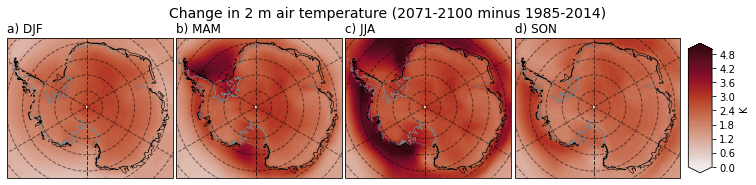

In [24]:
p = plot_CMIP(models_tas.tas,'Change in 2 m air temperature (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,5.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tas.pdf')

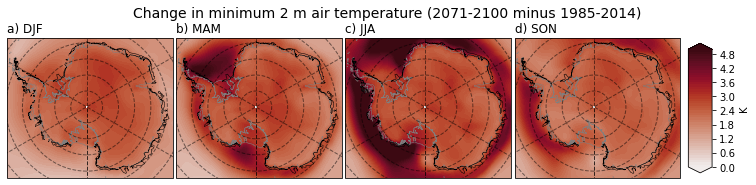

In [25]:
p = plot_CMIP(models_tasmin.tasmin,'Change in minimum 2 m air temperature (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,5.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tasmin.pdf')

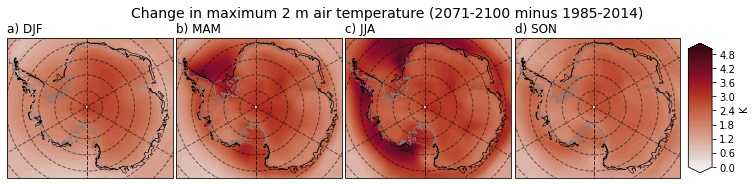

In [26]:
p = plot_CMIP(models_tasmax.tasmax,'Change in maximum 2 m air temperature (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,5.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tasmax.pdf')

### Liquid and ice precip

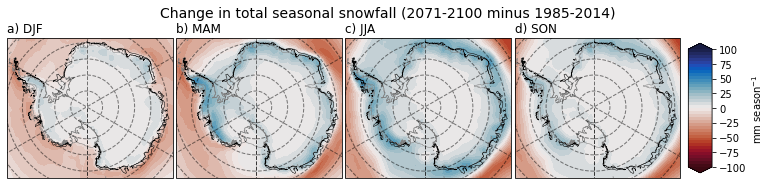

In [27]:
p = plot_CMIP(models_prsn.prsn,'Change in total seasonal snowfall (2071-2100 minus 1985-2014)','mm season$^{-1}$',
              levels=np.arange(-100,105,5),cmap2=cmocean.cm.balance_r)
plt.savefig('prsn.pdf')

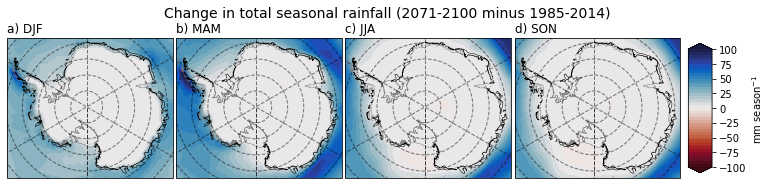

In [28]:
p = plot_CMIP(models_prl.prl,'Change in total seasonal rainfall (2071-2100 minus 1985-2014)','mm season$^{-1}$',
              levels=np.arange(-100,105,5),cmap2=cmocean.cm.balance_r)
plt.savefig('prl.pdf')

### MSLP

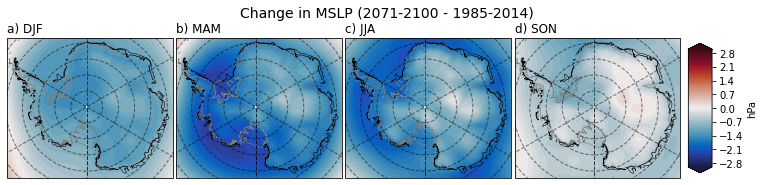

In [29]:
p = plot_CMIP(models_psl.psl,'Change in MSLP (2071-2100 - 1985-2014)','hPa',
              levels=np.arange(-3,3.1,0.1),cmap2=cmocean.cm.balance)
plt.savefig('psl.pdf')

### Surface short wave downwelling raditaion

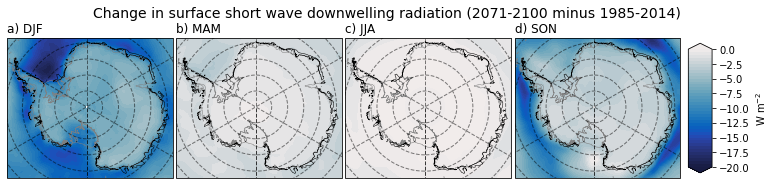

In [37]:
p = plot_CMIP(models_rsds.rsds,'Change in surface short wave downwelling radiation (2071-2100 minus 1985-2014)','W m$^{-2}$',
              levels=np.arange(-20,0.5,0.5),cmap2=truncate_colormap(cmocean.cm.balance,0,0.5))
plt.savefig('rsds.pdf')

### Wind 

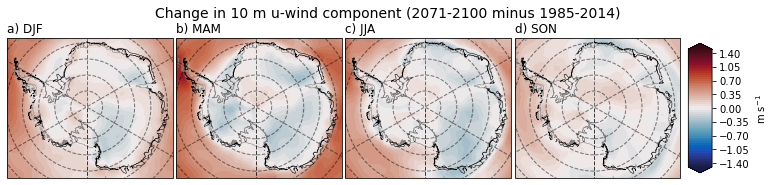

In [31]:
p = plot_CMIP(models_uas.uas,'Change in 10 m u-wind component (2071-2100 minus 1985-2014)','m s${^{-1}}$',
              levels=np.arange(-1.5,1.55,0.05),cmap2=cmocean.cm.balance)
plt.savefig('uas.pdf')

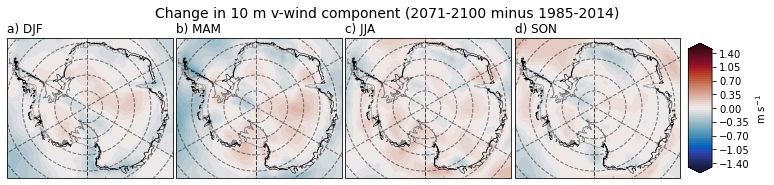

In [32]:
p = plot_CMIP(models_vas.vas,'Change in 10 m v-wind component (2071-2100 minus 1985-2014)','m s${^{-1}}$',
              levels=np.arange(-1.5,1.55,0.05),cmap2=cmocean.cm.balance)
plt.savefig('vas.pdf')

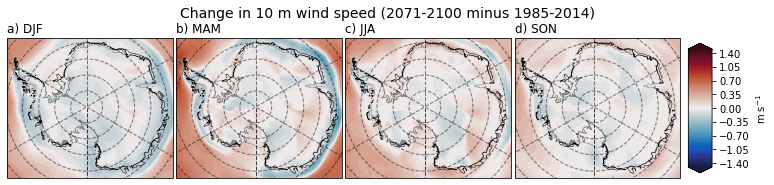

In [33]:
p = plot_CMIP(models_wspd.wspd,'Change in 10 m wind speed (2071-2100 minus 1985-2014)','m s${^{-1}}$',
              levels=np.arange(-1.5,1.55,0.05),cmap2=cmocean.cm.balance)
plt.savefig('wspd.pdf')

### SSTs

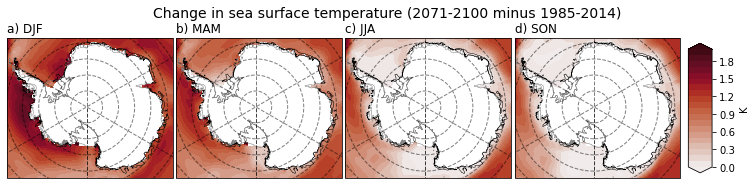

In [34]:
p = plot_CMIP(models_tos.tos,'Change in sea surface temperature (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,2.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tos.pdf')

### Sea ice conc

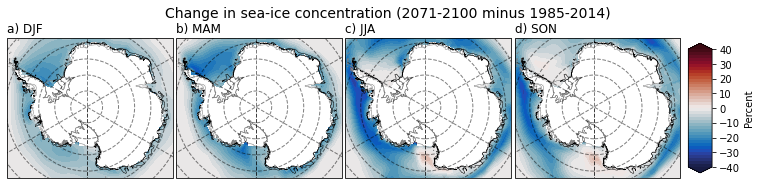

In [35]:
p = plot_CMIP(models_siconc.siconc,'Change in sea-ice concentration (2071-2100 minus 1985-2014)','Percent',
              levels=np.arange(-40,42,2),cmap2=cmocean.cm.balance)
plt.savefig('siconc.pdf')

### Sea ice thickness

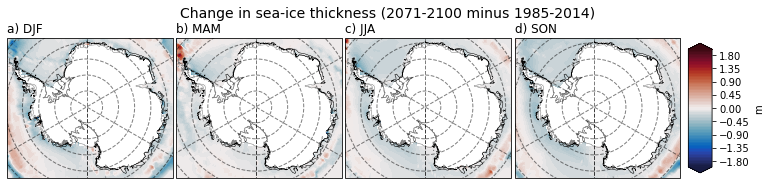

In [36]:
p = plot_CMIP(models_sithick.sithick,'Change in sea-ice thickness (2071-2100 minus 1985-2014)','m',
              levels=np.arange(-2,2.05,0.05),cmap2=cmocean.cm.balance)
plt.savefig('sithick.pdf')